In [33]:
# Installing the packages.
import pandas as pd
import numpy as np
from sklearn import preprocessing, model_selection, metrics
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier

# Loading the data. To speed up the process,
# I decided to use only two CSV files.
approve = pd.read_csv("LoanStats3a.csv", skiprows=1, low_memory=False)
reject = pd.read_csv("RejectStatsA.csv", skiprows=1, low_memory = False)

## Data Cleaning

I manually examined the dataset and found some columns that appear in both "approve" and "reject" datasets:

1. Amount Requested & loan_amnt

2. Loan Title & purpose

3. Debt-toi-Income Ratio & dti

4. Zip Code & zip_code

5. State & addr_state

6. Employment Length & emp_length

7. Policy Code & policy_code

I subsetted these columns from the datasets and added a "Status" column that indicated whether the loan was rejected or approved for a given individual.

In [12]:
# Subsetting columns that are present in both datasets
approve_sub = approve.loc[:,["loan_amnt", "purpose", "dti", "zip_code", 
                          "addr_state", "emp_length", "policy_code"]]

reject_sub = reject.loc[:,["Amount Requested", "Loan Title",
                           "Debt-To-Income Ratio", "Zip Code", 
                        "State", "Employment Length", "Policy Code"]]

# Adding a "Status" column that signifies whether the loan 
# was approved (1) or rejected (0)
reject_sub["Status"] = 0
approve_sub["Status"] = 1

After that, I changed the names of the "approve" dataset to the ones used in "reject" and combined two datasets. I checked for NAs and realized there were not as many of them given the amount of data that we have. So I decided to drop the rows which have missing values.

In [3]:
# Changing the names
approve_sub.columns = reject_sub.columns

# Combine two datasets together
data = pd.concat([approve_sub, reject_sub])
data.reset_index(inplace=True, drop=True)

# Check for NAs and drop them as they don't have much influence
print data.isnull().sum()
data.dropna(inplace=True)

Amount Requested         3
Loan Title               9
Debt-To-Income Ratio     3
Zip Code                25
State                   24
Employment Length        3
Policy Code              3
Status                   0
dtype: int64


I have noticed that two columns, "Zip Code" and "Debt-to-Income Ratio," can be transformed to integers. To do so, I decided to remove the "xx" from the codes and "%" from the ratios. I wrote two functions that perform these procedures and applied them to all the rows in the dataset so that the resulting values are integers.

In [4]:
def remove_x(x):
    """ Removes xx from the Zip Code column"""
    try:
        return float(x.strip("x"))
    except:
        return float(x)
    
def remove_percent(x):
    try:
        return float(x.strip("%"))
    except:
        return float(x)
    
data.loc[:,"Zip Code"] = data["Zip Code"].apply(remove_x)
data.loc[:,"Debt-To-Income Ratio"] = data
        ["Debt-To-Income Ratio"].apply(remove_percent)
data.head()    

,Amount Requested,Loan Title,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code,Status
0,5000.0,credit_card,27.65,860.0,AZ,10+ years,1.0,1
1,2500.0,car,1.00,309.0,GA,< 1 year,1.0,1
2,2400.0,small_business,8.72,606.0,IL,10+ years,1.0,1
3,10000.0,other,20.00,917.0,CA,10+ years,1.0,1
4,3000.0,other,17.94,972.0,OR,1 year,1.0,1


After that, I worked with the "Employment Length" column which included the years from 0 to 10. I first transformed NAs to "less than 1 year" and then wrote the encoder function that tuns all the years into integers (0 for < 1 year and 10 for 10+ years).

In [5]:
# Cleaning the Employment Length column

# Group NAs with < 1
data.loc[:, "Employment Length"] = data["Employment Length"]
                .replace(to_replace=["n/a"], value="< 1 year")

def encoder(x):
    """ Transform years into integers"""
    if "<" in str(x):
        print "yes"
        return 0
    elif "10" in str(x):
        return 10
    else:
        return x
    
# Apply this function on the column
years_encoder = preprocessing.LabelEncoder()
data["Employment Length"] = years_encoder
                .fit_transform(data["Employment Length"])
data["Employment Length"] = data["Employment Length"].apply(encoder)
data.head()

,Amount Requested,Loan Title,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code,Status
0,5000.0,credit_card,27.65,860.0,AZ,1,1.0,1
1,2500.0,car,1.00,309.0,GA,10,1.0,1
2,2400.0,small_business,8.72,606.0,IL,1,1.0,1
3,10000.0,other,20.00,917.0,CA,1,1.0,1
4,3000.0,other,17.94,972.0,OR,0,1.0,1


I realized that "Loan Title" had way too many different categories. To reduce their number, I examined all of them and identified several prominent categories. I then grouped some of the values (e.g., all that had "home" or "house" to house_purchase) using the combine function. As a result, I got 12 different types of loans including "other" which included everything which couldn't be categorized by combine.

In [6]:
# Cleaning the Loan Title column
def combine(x):
    """ Combine different loan types into a few most popular."""
    if "credit" in x.lower():
        return "credit_card"
    elif "moving" in x.lower():
        return "moving"
    elif "car" in x.lower():
        return "car"
    elif "debt" in x.lower():
        return "debt_consolidation"
    elif "improv" in x.lower():
        return "home_improvement"
    elif "home" in x.lower() or "house" in x.lower():
        return "house_purchase"
    elif " vacation" in x.lower():
        return "vacation"
    elif "medical" in x.lower():
        return "medical"
    elif "business" in x.lower():
        return "business"
    elif "major" in x.lower():
        return "major_purchase"
    elif "energy" in x.lower() or "green" in x.lower():
        return "renewable_energy"
    else:
        return "other"

data["Loan Title"] = data["Loan Title"].apply(combine)
data["Loan Title"].unique()

array(['credit_card', 'car', 'business', 'other', 'debt_consolidation',
       'home_improvement', 'major_purchase', 'medical', 'moving',
       'house_purchase', 'renewable_energy', 'vacation'], dtype=object)

After that, I decided to get rid of the categorical variables with the help of the one-hot encoding. I created dummy variables for the "Loan Title" and "State," which was the final stage of my data cleaning. With this dataset at hands, I'm ready to build the model.

In [7]:
# Dummy variables for states and loan titles
data = pd.get_dummies(data, 
            columns=["Loan Title", "State"], drop_first = True)
data.head()

,Amount Requested,Debt-To-Income Ratio,Zip Code,Employment Length,Policy Code,Status,Loan Title_car,Loan Title_credit_card,Loan Title_debt_consolidation,Loan Title_home_improvement,...,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,5000.0,27.65,860.0,1,1.0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2500.0,1.00,309.0,10,1.0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2400.0,8.72,606.0,1,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10000.0,20.00,917.0,1,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3000.0,17.94,972.0,0,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Linear Model

I decided to build a logistic regression model which is trained on one subset of the data and tested on the other.

I first split the data into subsets and dropped "Loan_Title_other" as it is not a particular type of loan but an aggregate of all different types and "Policy code" as it is almost 100% correlated with the "Status" that the model aims to predict which can lead to misleading results and undermine the importance of other variables.

In [8]:
# Split the data into test and training sets
X = data[[i for i in data.columns if "Status" not in i]]
y = data["Status"]
del X['Loan Title_other']
del X['Policy Code']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,
                                            stratify=y, test_size=0.3)

As the outcome is measured with a dichotomous variable (either approved or rejected), I decided to use logistic regression. 

To avoid overfitting, I used LogisticRegressionCV class that implements logistic regression using liblinear optimizer. The liblinear solver is a linear classifier for big datasets. It supports L1 regularization which is more robust compared to L2. 

Cross-validation evaluates how well a model performs in predicting the dependent variable on different subsets of the data. It partitions the data into k equally sized folds. One fold is held out for validation while the other k-1 folds are used to train the model. This process is repeated k times. The performance is tracked using the F1 scoring metric which is a weighted average of the precision and recall. This particular method uses stratified k-fold cross-validation by default. The folds are selected so that the mean response value is approximately equal in all the folds. In the case of a dichotomous classification, it means that each fold contains roughly the same proportions of the two types of class labels.

After fitting the model, I predicted the outcome on the test set and evaluated the model's performance using different metrics.

From the classification report, you can see that the model has high enough precision, recall, and f1 score. However, these numbers are tricky since the model doesn't perform well when it comes to classifying approved loans (20% precision). Confusion matrix also shows that the model is definitely biased towards "rejected." One of the reasons for that is that I loaded much more data for rejected loans (755491 vs. 42535).

Mutual information is a quantity that measures how much one random variable tells about another. It can be thought of as the reduction in uncertainty about one random variable given knowledge of another. Low mutual information that I got (0.038) indicates a small reduction in uncertainty.

             precision    recall  f1-score   support

          0       0.98      0.83      0.90    226639
          1       0.20      0.74      0.31     12761

avg / total       0.94      0.82      0.87    239400

Confusion matrix:
[[188054  38585]
 [  3373   9388]]
Mutual information:
0.03819710982826479


/usr/local/lib/python2.7/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


('AUC:', 0.8425103442224837)


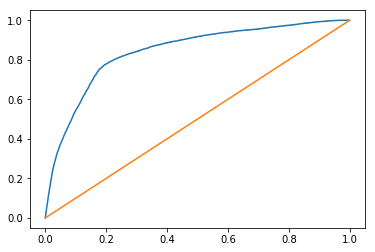

In [11]:
logreg = linear_model.LogisticRegressionCV(penalty='l1',
            class_weight='balanced', solver='liblinear',
            Cs=[0.01, 0.001], refit=True, scoring='f1')

logreg.fit(X_train, y_train)

pred = logreg.predict(X_test)

print metrics.classification_report(y_test, pred)
print "Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, pred)

print("Mutual information:\n%s" %metrics.mutual_info_score(y_test,
                                            pred, contingency=None))
pred_probs = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_probs)

import matplotlib.pyplot as plt
% matplotlib inline
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
print("AUC:", metrics.auc(fpr,tpr))

## Random Forest

After fitting the logistic model and identifying some of its disadvantages, I decided to create a different model using random forests. Even though I managed to improve the precision for an approved loan, the overall accuracy of the model hasn't increased much; the numbers are comparable to the output of logistic regression.

             precision    recall  f1-score   support

          0       0.96      0.99      0.97    226639
          1       0.53      0.25      0.34     12761

avg / total       0.94      0.95      0.94    239400

Confusion matrix:
[[223734   2905]
 [  9507   3254]]
Mutual information:
0.024369549509573527
('AUC:', 0.8469423030016174)


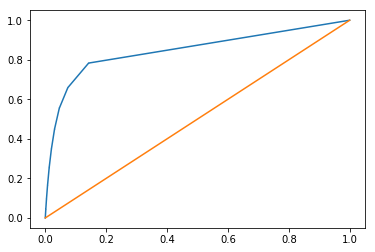

In [10]:
# Evaluate Random Forest Classifier
rf = RandomForestClassifier(class_weight='balanced')

rf.fit(X_train, y_train)

prediction = rf.predict(X_test)

print metrics.classification_report(y_test, prediction)
print "Confusion matrix:\n%s" % metrics.confusion_matrix(y_test,
                                                    prediction)

print("Mutual information:\n%s" %metrics.mutual_info_score(y_test,
                                    prediction, contingency=None))
prediction_probs = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, prediction_probs)

import matplotlib.pyplot as plt
% matplotlib inline
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
print("AUC:", metrics.auc(fpr,tpr))

The initial task was to predict the largest loan amount that will be successfully funded for a given individual. To do so, I kept all the variables constant for one person and varied the amount of money requested until the model predicted it to be rejected (which is the cut-off point). As a result, I get the maximum loan amount possible and print it out. 

In some cases, this approximator outputs a zero. The reason for that is that some loan titles are very important predictors (people are very likely to get approval for a credit card and much less likely to get it for a house purchase), that's why it's almost impossible to get any loan for some of the titles.

In [47]:
# Choose a random individual from the dataset
# by changing the row number.
individual = X.iloc[0,:].copy()

for i in range(1000, 100000, 1000):
    individual[0] = i
    prediction = logreg.predict([individual])
    if prediction == 0:
        print "The predicted largest loan amount is $" + str(i-1000) + "."
        break


The predicted largest loan amount is $83000.
